# 01 – Data Preparation for Semantic Scientific Paper Recommender

In this notebook, we'll perform the following:
- Load / Download the raw arXiv scientific papers dataset from Kaggle.
- Inspects the columns (title, abstract, categories, etc.).
- Normalizes column names to a consistent schema
- Creates a combined `text` field = title + abstract.
- Saves the cleaned dataset to `data/clean_papers.csv` for later notebooks.

Dataset link: https://www.kaggle.com/datasets/sumitm004/arxiv-scientific-research-papers-dataset/data

In [1]:
import os
import pandas as pd

RAW_DATA_PATH = "../data/arxiv_papers.csv"
CLEAN_DATA_PATH = "../data/clean_papers.csv"

In [3]:
df_raw = pd.read_csv(RAW_DATA_PATH)

print("Raw shape:", df_raw.shape)

df_raw.head(3)

Raw shape: (136238, 10)


,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167


In [4]:
df_raw.columns.tolist()

['id',
 'title',
 'category',
 'category_code',
 'published_date',
 'updated_date',
 'authors',
 'first_author',
 'summary',
 'summary_word_count']

In [5]:
columns_to_keep = [
    "id",
    "title",
    "summary",
    "category",
    "category_code",
    "published_date",
    "authors"
]

# Verify all exist in dataset
missing = [c for c in columns_to_keep if c not in df_raw.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

df = df_raw[columns_to_keep].copy()
df.head(3)

,id,title,summary,category,category_code,published_date,authors
0,cs-9308101v1,Dynamic Backtracking,Because of their occasional need to return to ...,Artificial Intelligence,cs.AI,8/1/93,['M. L. Ginsberg']
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,Artificial Intelligence,cs.AI,8/1/93,['M. P. Wellman']
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,Artificial Intelligence,cs.AI,9/1/93,"['I. P. Gent', 'T. Walsh']"


Clean Missing and Duplicates

In [6]:
# Drop rows missing title or summary
df = df.dropna(subset=["title", "summary"])

# Drop duplicate titles
before = len(df)
df = df.drop_duplicates(subset=["title"]).reset_index(drop=True)
after = len(df)
print(f"Dropped {before - after} duplicate titles.")

Dropped 84 duplicate titles.


Combined Text Field

In [7]:
# Combine title + summary for embedding input
df["text"] = df["title"].str.strip() + ". " + df["summary"].str.strip()

# Check sample
df[["title", "summary", "text"]].head(3)

,title,summary,text
0,Dynamic Backtracking,Because of their occasional need to return to ...,Dynamic Backtracking. Because of their occasio...
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,A Market-Oriented Programming Environment and ...
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,An Empirical Analysis of Search in GSAT. We de...


Parse Dates into a standard format

In [ ]:
# Convert published_date to datetime
df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")

# Extract publication year for future filtering
df["year"] = df["published_date"].dt.year

# check
df[["published_date", "year"]].head(3)

/var/folders/xj/d4yfsp6j44s6591wzrszs34w0000gn/T/ipykernel_79805/312052862.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")


,published_date,year
0,1993-08-01,1993
1,1993-08-01,1993
2,1993-09-01,1993


Code below is for downsampling just incase we run into memory problems

In [9]:
# adjust to a specific value (5000) or set to None for all papers

MAX_PAPERS = None  

if MAX_PAPERS is not None and len(df) > MAX_PAPERS:
    df = df.sample(MAX_PAPERS, random_state=42).reset_index(drop=True)

len(df)

136154

Save a cleaned Dataset

In [10]:
os.makedirs(os.path.dirname(CLEAN_DATA_PATH), exist_ok=True)
df.to_csv(CLEAN_DATA_PATH, index=False)

print(f"Saved cleaned dataset to: {CLEAN_DATA_PATH}")
print("Final shape:", df.shape)
df.head(3)

Saved cleaned dataset to: ../data/clean_papers.csv
Final shape: (136154, 9)


,id,title,summary,category,category_code,published_date,authors,text,year
0,cs-9308101v1,Dynamic Backtracking,Because of their occasional need to return to ...,Artificial Intelligence,cs.AI,1993-08-01,['M. L. Ginsberg'],Dynamic Backtracking. Because of their occasio...,1993
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,Artificial Intelligence,cs.AI,1993-08-01,['M. P. Wellman'],A Market-Oriented Programming Environment and ...,1993
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,Artificial Intelligence,cs.AI,1993-09-01,"['I. P. Gent', 'T. Walsh']",An Empirical Analysis of Search in GSAT. We de...,1993


Basic Data Insights

In [11]:
# Basic dataset overview
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136154 entries, 0 to 136153
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              136154 non-null  object        
 1   title           136154 non-null  object        
 2   summary         136154 non-null  object        
 3   category        136154 non-null  object        
 4   category_code   136154 non-null  object        
 5   published_date  136154 non-null  datetime64[ns]
 6   authors         136154 non-null  object        
 7   text            136154 non-null  object        
 8   year            136154 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(7)
memory usage: 8.8+ MB


,id,title,summary,category,category_code,published_date,authors,text,year
count,136154,136154,136154,136154,136154,136154,136154,136154,136154.000000
unique,136154,136154,136130,138,139,NaN,125516,136154,NaN
top,cs-9308101v1,Dynamic Backtracking,This paper aims at improving the classificatio...,Machine Learning,cs.LG,NaN,['Mieczysław A. Kłopotek'],Dynamic Backtracking. Because of their occasio...,NaN
freq,1,1,2,39965,39965,NaN,22,1,NaN
mean,NaN,NaN,NaN,NaN,NaN,2019-10-25 09:53:10.804530176,NaN,NaN,2019.310678
min,NaN,NaN,NaN,NaN,NaN,1993-08-01 00:00:00,NaN,NaN,1993.000000
25%,NaN,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,NaN,NaN,2018.000000
50%,NaN,NaN,NaN,NaN,NaN,2020-06-30 00:00:00,NaN,NaN,2020.000000
75%,NaN,NaN,NaN,NaN,NaN,2022-09-20 00:00:00,NaN,NaN,2022.000000
max,NaN,NaN,NaN,NaN,NaN,2025-01-30 00:00:00,NaN,NaN,2025.000000


Text Length Analysis

           title_len    summary_len      text_len
count  136154.000000  136154.000000  136154.00000
mean       73.556421    1128.035768    1203.59219
std        24.452079     343.495692     348.95192
min         6.000000       3.000000      59.00000
25%        56.000000     890.000000     963.00000
50%        71.000000    1118.000000    1194.00000
75%        89.000000    1358.000000    1437.00000
max       245.000000    3658.000000    3711.00000


array([[<Axes: title={'center': 'title_len'}>,
        <Axes: title={'center': 'summary_len'}>]], dtype=object)

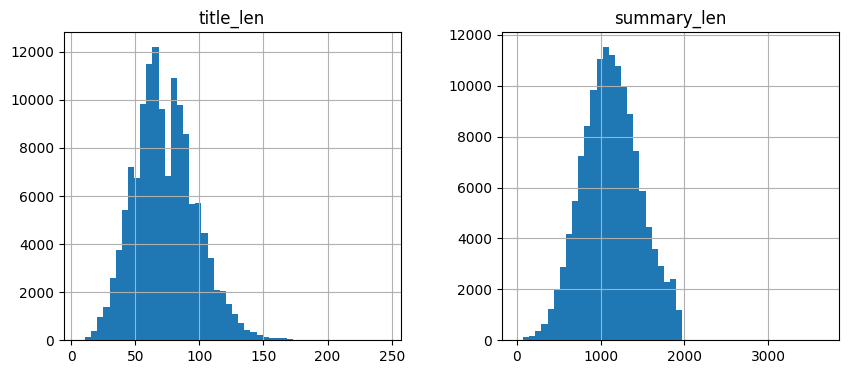

In [14]:
# Compute text lengths
df["title_len"] = df["title"].apply(len)
df["summary_len"] = df["summary"].apply(len)
df["text_len"] = df["text"].apply(len)

# Summary statistics
print(df[["title_len", "summary_len", "text_len"]].describe())

# Plot histograms
df[["title_len", "summary_len"]].hist(bins=50, figsize=(10,4))

Category Distribution

Top categories:
                                              category  count
0                                    Machine Learning  39965
1             Computer Vision and Pattern Recognition  29049
2   Computation and Language (Natural Language Pro...  25196
3                             Artificial Intelligence  12945
4                       Machine Learning (Statistics)  10430
5                   Neural and Evolutionary Computing   5508
6                                            Robotics    903
7                               Information Retrieval    901
8                            Methodology (Statistics)    882
9                            Optimization and Control    749
10         Computation and Language (Legacy category)    744
11                          Cryptography and Security    665
12                              Computers and Society    515
13                    Social and Information Networks    417
14                         Human-Computer Interaction    411
15     

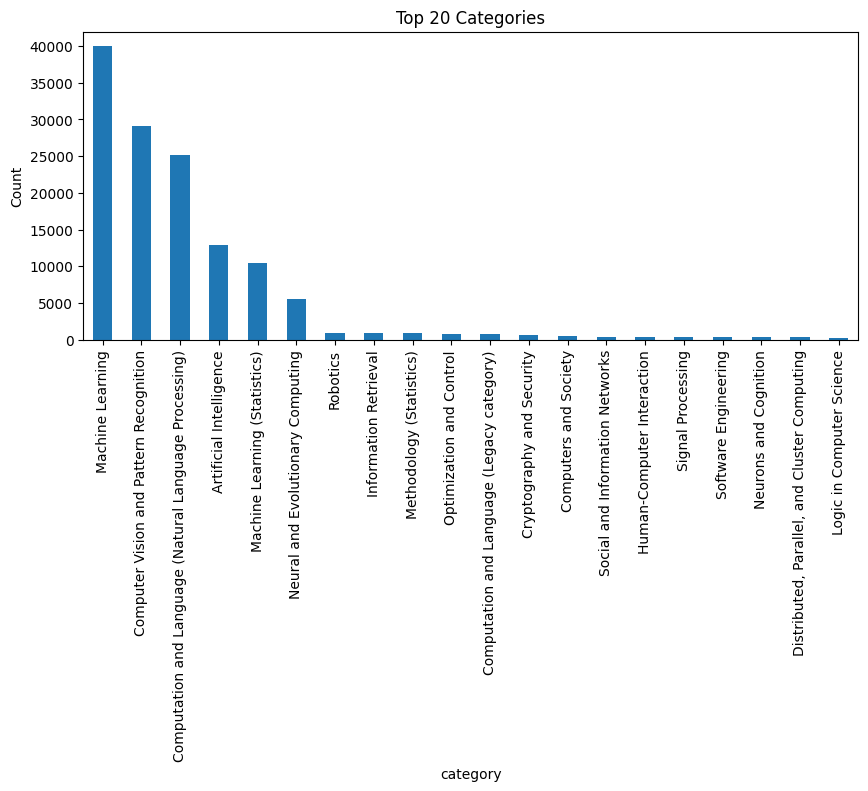


Top category codes:
    category_code  count
0          cs.LG  39965
1          cs.CV  29049
2          cs.CL  25196
3          cs.AI  12945
4        stat.ML  10430
5          cs.NE   5508
6          cs.RO    903
7          cs.IR    901
8        stat.ME    882
9        math.OC    749
10        cmp-lg    744
11         cs.CR    665
12         cs.CY    515
13         cs.SI    417
14         cs.HC    411
15       eess.SP    405
16         cs.SE    382
17      q-bio.NC    362
18         cs.DC    298
19       stat.AP    279


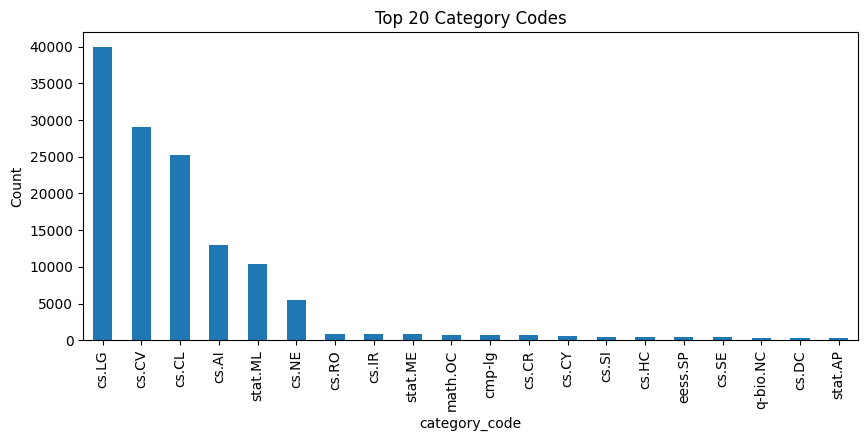

In [ ]:
import matplotlib.pyplot as plt

# Plot category distribution
if "category" in df.columns:
    top_categories = (
        df["category"]
        .value_counts()
        .head(20)
        .rename_axis("category")
        .reset_index(name="count")
    )

    print("Top categories:\n", top_categories)
    top_categories.plot.bar(x="category", y="count", figsize=(10,4), legend=False)
    plt.title("Top 20 Categories")
    plt.ylabel("Count")
    plt.show()

# Plot category_code distribution
if "category_code" in df.columns:
    top_codes = (
        df["category_code"]
        .value_counts()
        .head(20)
        .rename_axis("category_code")
        .reset_index(name="count")
    )

    print("\nTop category codes:\n", top_codes)
    top_codes.plot.bar(x="category_code", y="count", figsize=(10,4), legend=False)
    plt.title("Top 20 Category Codes")
    plt.ylabel("Count")
    plt.show()